# Trabalho 2
## Lógica Computacional 2020-2021

> O objetivo deste trabalho é a modelação de grafos,  em Z3 e  NetworkX.

> Trabalho realizado por: 
    > 1. Paulo Costa - A87986
    > 2. André Araújo - A87987

### Exercício 2 
2. Considere circuitos aritméticos $\,N\times 1\,$ (N inputs e 1 output), com “wires” de 16 bits  e “gates” de três tipos: 
        
     i. a “gate” binária $\,\oplus\,$ implementa $\mathtt{xor}\,$ bit a bit   
     ii. a “gate” binária$\,+\,$ implementa soma aritmética ($\mathtt{add}$) de inteiros módulo $\,2^{16}\,$                               
    iii. a “gate”  unária $\,\gg_r \,$ implementa o “right-shift-rotate” do argumento um número de posições dado pela constante $0<r< 16$.
   
   Os parâmetros do circuito são o número de inputs $N$, o número de “gates” $M$ e a razão $\gamma\,$ entre o número de “gates”  $\,\mathtt{add}\,$ e o número total de “gates”.
    
    Neste problema \
    a. É dado um circuito aleatoriamente gerado com parâmetros $\,N,M\,\text{e}\,\gamma\,$. \
    b. São dados também  o valor do output final e o “output” de todas as “gates”  $\,\mathtt{add}\,$. \
    Pretende-se usar Z3 para determinar se os dados são consistentes entre si e, se forem, determinar  inputs que sejam compatíveis com tais outputs.

## Resolução:

> Primeiramente, através dos parametros $\,N,M\,\text{e}\,\gamma\,$, geramos um circuito onde primeiro criámos os nodos de input, output e valores. \
\
Em seguida, para cada gate, escolhemos o seu output, entre os valores e o output do circuito, caso seja uma gate add, geramos um valor para ele uma vez e depois escolhemos o input da gate entre os inputs e os valores. \
\
No final, verificamos se não tem ciclos e, caso o output não seja resultado de uma gate add geramos um valor output para o circuito. Verificamos ainda que cada input é usado, e que cada valor é output de uma gate e é input de pelo menos uma gate,
caso não seja verdade geramos outro circuito.

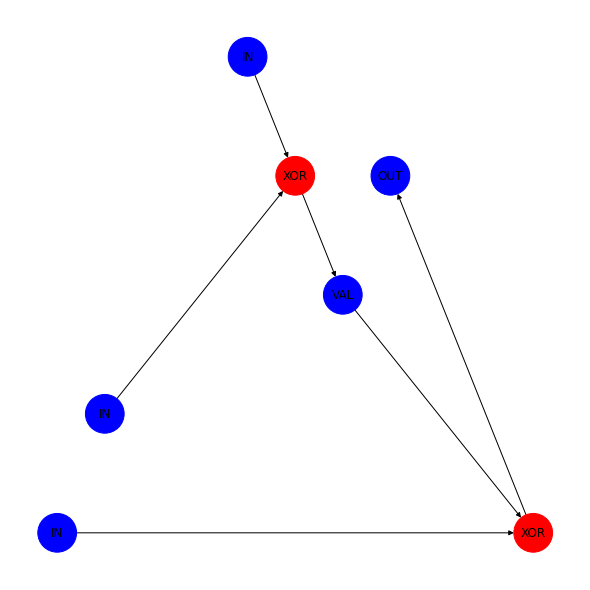

In [3]:
from z3 import *
import networkx as nx
from random import randint,random,uniform
import matplotlib.pyplot as pyplt


def fromBin(a):
    r = 0
    for i in range(16):
        r = 2*r
        if (a[i]=='1'):
            r = r+1
    return r

def toBin(a):
    r = []
    for _ in range(32):
        r.insert(0,'1' if a%2==1 else '0')
        a = a//2
    return ''.join(r)

def geraOutput16():
    s=""
    for i in range(16):
        s+=str(randint(0,1))
    return s


# agora, criámos 2 funções que têm como intuito gerar um output e um input, repetivamente #

def addOut(G,l,i,N,M,d,add,ladd):
    r=randint(N,N+M-1)
    while r in l:
        r=randint(N,N+M-1)
    l.append(r)
    G.add_edge(i,r)
    d[i].append(r)
    if add==1:
        ladd[r]=geraOutput16()
    return G,l,ladd

def addInput(G,ant,i,N,M,d):
    r=randint(0,N+M-2)
    while r==ant:
        r=randint(0,N+M-2)
    G.add_edge(r,i)
    d[i].append(r)
    return G,r


def geracircuitosaux(N,M,r):
    erro=0
    eCiclo=True
    f=0
    d={}
    output=geraOutput16()
    nadd=round(M*r)
    ladd={}
    if N==1 and nadd >0:
        erro=1
    G=nx.DiGraph()
    cores=[]
    while eCiclo==True and erro ==0:
        cores=[]
        G=nx.DiGraph()
        l=[]
        d={}
        ladd={}
        add=0
        for i in range(0,N+2*M):
            if i<N:
                G.add_node(i)
                G.nodes[i]["tipo"]="IN"
                cores.append('blue')
            elif i<N+M-1:
                G.add_node(i)
                G.nodes[i]["tipo"]="VAL"
                cores.append('blue')
            elif i<N+M:
                G.add_node(i)
                G.nodes[i]["tipo"]="OUT"
                output=i
                cores.append('blue')
            elif i<nadd+N+M:
                G.add_node(i)
                G.nodes[i]["tipo"]="ADD"
                cores.append('red')
                d[i]=[]
                add=1
                G,l,ladd=addOut(G,l,i,N,M,d,add,ladd)
                add=0
                G,k=addInput(G,l[-1],i,N,M,d)
                G,_=addInput(G,k,i,N,M,d)
            else:
                G.add_node(i)
                d[i]=[]
                add=0
                nt=randint(0,1)
                cores.append('red')
                if nt==0:
                    G.nodes[i]["tipo"]="XOR"
                    G,l,ladd=addOut(G,l,i,N,M,d,add,ladd)
                    G,k=addInput(G,l[-1],i,N,M,d)
                    G,_=addInput(G,k,i,N,M,d)
                else:
                    G.nodes[i]["tipo"]="ROT"
                    G,l,ladd=addOut(G,l,i,N,M,d,add,ladd)
                    G,_=addInput(G,l[-1],i,N,M,d)     
        if output not in ladd:
            output=output,geraOutput16()
        else:
            output=output,ladd[output]
        eCiclo = len(list(nx.simple_cycles(G))) > 0
    return G,d,output,ladd,cores

def geracircuito(N,M,r):
    while(True):
        f=1
        G,dic,output,ladd,cores=geracircuitosaux(N,M,r)
        d=nx.get_node_attributes(G,'tipo')
        for key in d:
            if d[key]=='VAL':
                if len(G.in_edges(key))==0 or len(G.out_edges(key))==0:
                    f=0
            elif d[key]=='IN':
                if len(G.out_edges(key))==0:
                    f=0
        if f==1:
            break
            
    k=0
    for i in dic:
        dic[i].sort()
    d = nx.get_node_attributes(G,'tipo')
    labels = nx.get_node_attributes(G, 'tipo') 
    posicao = nx.planar_layout(G)
    pyplt.figure(figsize=(8,8))
    nx.draw(G, pos= posicao, labels=labels,node_size=1500,node_color=cores)
    return N,M,r,output,ladd,G,dic

N=randint(2,4)
M=randint(2,5)
r=round(uniform(0,1),2)
N,M,r,output,ladp,G,d=geracircuito(N,M,r)



## Resolução:

> Na alínea (b), criámos bitvectors $bitvec_i$ para guardar o valor lógico de cada variável. Depois, fomos ao circuito e percorremos todas as gates para ver qual é o seu tipo, e as wires usadas por essa gate que estão guardadas no dicionario $dic$. \
\
Caso a gate, seja Add tem $input_1,input_2$, como inputs e $output$, como output: \
\
$$input_1<=output 
\\
input_2<=output
\\
input_1\,+\,input_2=output
$$ \
Caso a gate, seja Xor tem $input_1,input_2$, como inputs e $output$, como output: \
\
$$input_1 \,\oplus\, input_2=output$$\
\
Caso a gate, seja “right-shift-rotate” tem $input_1$, como input e $output$, como output: \
\
$$\forall_{1\leq n\leq 15} \cdot \bigvee_{n \geq 1}^{15}\,\gg_n \,input_1=output$$ \
\
No final, verificamos se é consistente, e caso o seja, apresentamos alguns exemplos de inputs em inteiro e binário.


In [4]:

def rsrot(v,n):
    return  ((v>>n) | (v<<16-n))

def determinainput(G,dic,N,output,ladp):
    s=Solver()
    bitvec={}
    
    # Adicionar valores bitvec #
    for i in range(N+M):
        if i not in ladp and i !=output[0]:
            bitvec[i]=BitVec("bitvec "+str(i),16)
        elif i in ladp:
            bitvec[i]=fromBin(ladp[i])
        else:
            bitvec[i]=fromBin(output[1])
    # Adicinar condições ao solver #
    for i in dic:
        if G.nodes[i]['tipo']=='ADD':
            
            a=bitvec[dic[i][0]]                 # dic[i][0] é o primeiro input da gate i #
            b=bitvec[dic[i][1]]                 # dic[i][1] é o segundo input da gate i #
            
            # Adicionamos as restrições do add ao solver #
            
            s.add(a<=bitvec[dic[i][2]])
            s.add(b<=bitvec[dic[i][2]])
            s.add(a + b==bitvec[dic[i][2]])
            
        elif G.nodes[i]['tipo']=='XOR':
            
            a=bitvec[dic[i][0]]                  # dic[i][0] é o primeiro input da gate i #
            b=bitvec[dic[i][1]]                  # dic[i][1] é o segundo input da gate i #
            
            # Adicionamos as restrições do XOR ao solver #
            
            s.add(a ^ b==bitvec[dic[i][2]])
        else:
            a=bitvec[dic[i][0]]
            
            s.add(Or([(rsrot(a,n)==bitvec[dic[i][1]]) for n in range(1,15)]))
            
    n=0
    
    if s.check()!=sat:
        return 'inconsistentes'
    while s.check()== sat and n<3:
        print('Exemplo',n)
        m=s.model()
        res=""
        r=""
        for i in range(N-1):
            res+="input_"+str(i)+": "+toBin(m[bitvec[i]].as_long()) +',\n'
            r+="input_"+str(i)+": "+str(m[bitvec[i]].as_long())+',\n'
            s.add(bitvec[i] != m[bitvec[i]].as_long())
        i+=1
        res+="input_"+str(i)+": "+toBin(m[bitvec[i]].as_long()) +'\n'
        r+="input_"+str(i)+": "+str(m[bitvec[i]].as_long()) +'\n'
        s.add(bitvec[i] != m[bitvec[i]].as_long())
        print(res)
        print (r)
        n+=1


determinainput(G,d,N,output,ladp)

Exemplo 0
input_0: 00000000000000000000000000000000,
input_1: 00000000000000000000000000000000,
input_2: 00000000000000000000000111011011

input_0: 0,
input_1: 0,
input_2: 475

Exemplo 1
input_0: 00000000000000000000000000000001,
input_1: 00000000000000000000000111011010,
input_2: 00000000000000000000000000000000

input_0: 1,
input_1: 474,
input_2: 0

Exemplo 2
input_0: 00000000000000000000000000000010,
input_1: 00000000000000000000000111011000,
input_2: 00000000000000000000000000000001

input_0: 2,
input_1: 472,
input_2: 1



## Conclusão:

> Neste exercício, achamos sem dúvida que apesar de termos conseguido concluir o mesmo com sucesso, este deu-nos imenso trabalho, a nosso ver o mais díficil tanto do trabalho 1 como do 2. Talvez isto associado a um pouco de nervosismo e devido à divisão de tempos, algo que tivemos de fazer porque tinhamos teste dia 23/11 e ainda 24/11 e portanto acabamos por ter menos tempo para a realização do mesmo. \
\
Mas, apesar de tudo isto, achamos que com boa distribuição de tempo, de trabalho e com foco e foco, tivemos tempo necessário para conseguir um bom resultado neste exercício também, apesar de ser bastante mais complexo que os anteriores. \
\
Neste, declaramos como nossa maior dificuldade a interpretação do enunciado, isto, no sentido de que demoramos algum tempo a entender as ideias que necessitavamos para a sua resolução. \
\
Depois, foi sem dúvida o exercício que tivemos de efetuar mais "debugging", isto, porque tivemos de testar muitas vezes o exercício, visto que enquanto não estavamos a cumprir bem as restrições que este precisava, a nossa resolução acabava por entrar em ciclo. Portanto, também acabamos por ter algumas "dores de cabeça" neste sentido. \
\
Apesar de tudo isto, conseguimos uma solução muito positiva e que nos deixou de certa forma, contentes, porque acabamos por conseguir tudo, no tempo que delimitamos a cada tarefa, e não há nada melhor que isso associado a bons resultados.
Foi também muito interessante a resolução deste exercício apesar de tudo associado ao mesmo!


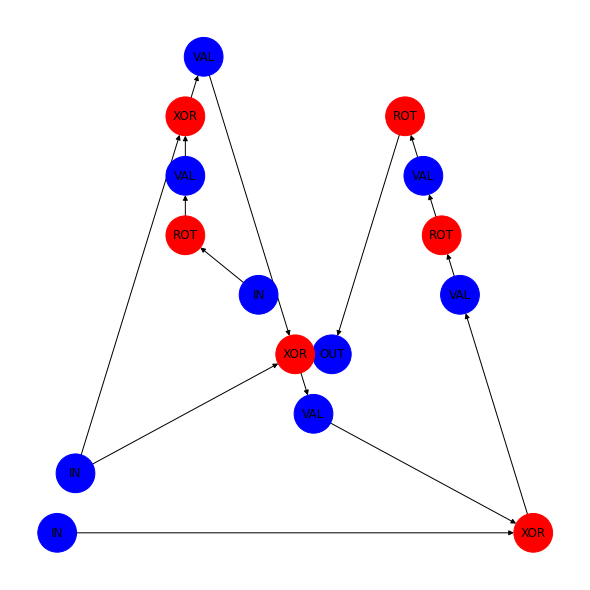

In [13]:
N=3
M=6
r=round(uniform(0,1),2)
N,M,r,output,ladp,G,d=geracircuito(N,M,r)


In [15]:
determinainput(G,d,N,output,ladp)

Exemplo 0
input_0: 00000000000000000011100110000000,
input_1: 00000000000000001101111111111110,
input_2: 00000000000000000101111111001111

input_0: 14720,
input_1: 57342,
input_2: 24527

Exemplo 1
input_0: 00000000000000001011101111110001,
input_1: 00000000000000000100000000000000,
input_2: 00000000000000000010000000000000

input_0: 48113,
input_1: 16384,
input_2: 8192

Exemplo 2
input_0: 00000000000000000111101111110001,
input_1: 00000000000000001100000000000000,
input_2: 00000000000000001010000000000000

input_0: 31729,
input_1: 49152,
input_2: 40960

